# Digging Into Data - Predict_Salary

In [1]:
%matplotlib inline

import data_io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,ExtraTreesRegressor,ExtraTreesClassifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error,confusion_matrix,accuracy_score,classification_report

#### The below code is adding salary bins to the train data set.

In [2]:
jobs_df = pd.read_csv('train-cedited.csv')

In [3]:
jobs_df['Salary_Range'] = "NA"
def func(row):
    if row['SalaryNormalized'] > 0 and row['SalaryNormalized'] < 20000:
        return '<20000'
    elif row['SalaryNormalized'] >= 20000  and row['SalaryNormalized'] < 27500:
        return '20001-27500'
    elif row['SalaryNormalized'] >= 27500  and row['SalaryNormalized'] < 37500:
        return '27500-37500'
    elif row['SalaryNormalized'] >= 37500  and row['SalaryNormalized'] < 60000:
        return '37500-60000'
    elif row['SalaryNormalized'] >= 60000:
        return '60000+'
    elif row['SalaryNormalized'] <= 0:
        return 'NA'
    else:
        return 'other'
jobs_df['Salary_Range'] = jobs_df.apply(func, axis=1)
jobs_df = jobs_df[jobs_df.Salary_Range != 'NA']

#### Created Histogram for SalaryNormalized

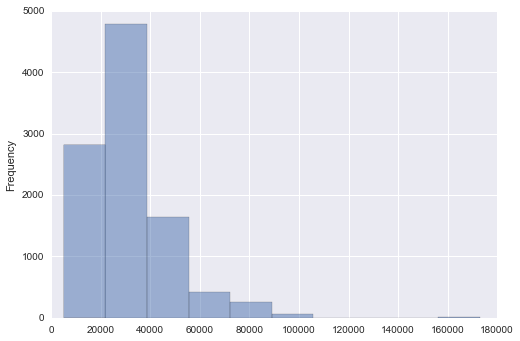

In [5]:
from seaborn import *
jobs_df['SalaryNormalized'].plot(kind='hist', alpha=0.5)

In [6]:
jobs_df.describe()

,Id,SalaryNormalized
count,10000.000000,10000.000000
mean,58883558.683700,31522.615600
std,7383340.440499,16153.358741
min,12612628.000000,5184.000000
25%,55408410.500000,20648.500000
50%,62005797.500000,27500.000000
75%,64796514.250000,37500.000000
max,66190737.000000,172800.000000


#### Create bar chart for salary range vs number of job ads

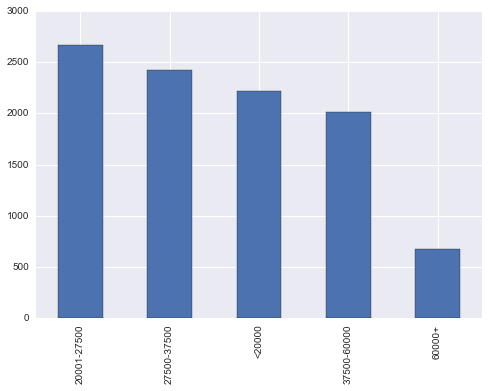

In [8]:
counts = jobs_df['Salary_Range'].value_counts()
counts.plot(kind='bar')

#### Created a bar chart for average salaries for each category

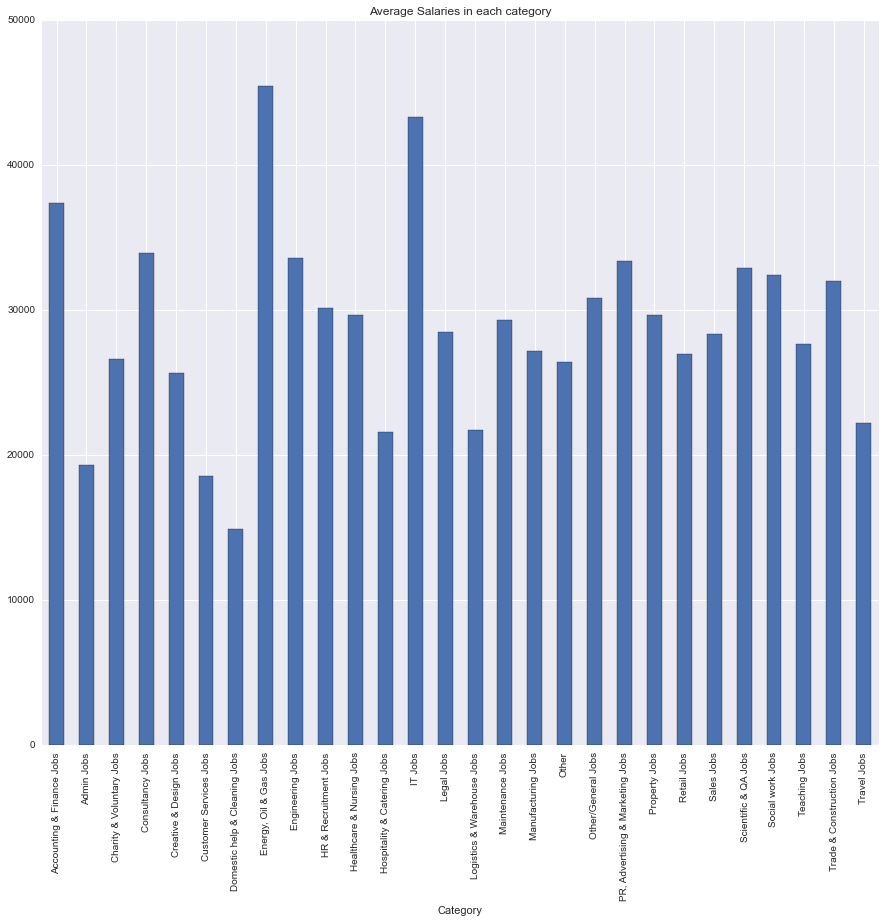

In [10]:
grp1 = jobs_df.groupby('Category')['SalaryNormalized'].mean()
my_plot1 = grp1.plot(kind='bar',title="Average Salaries in each category",figsize=(15, 13))

#### Created a bar chart for number of jobs in each category

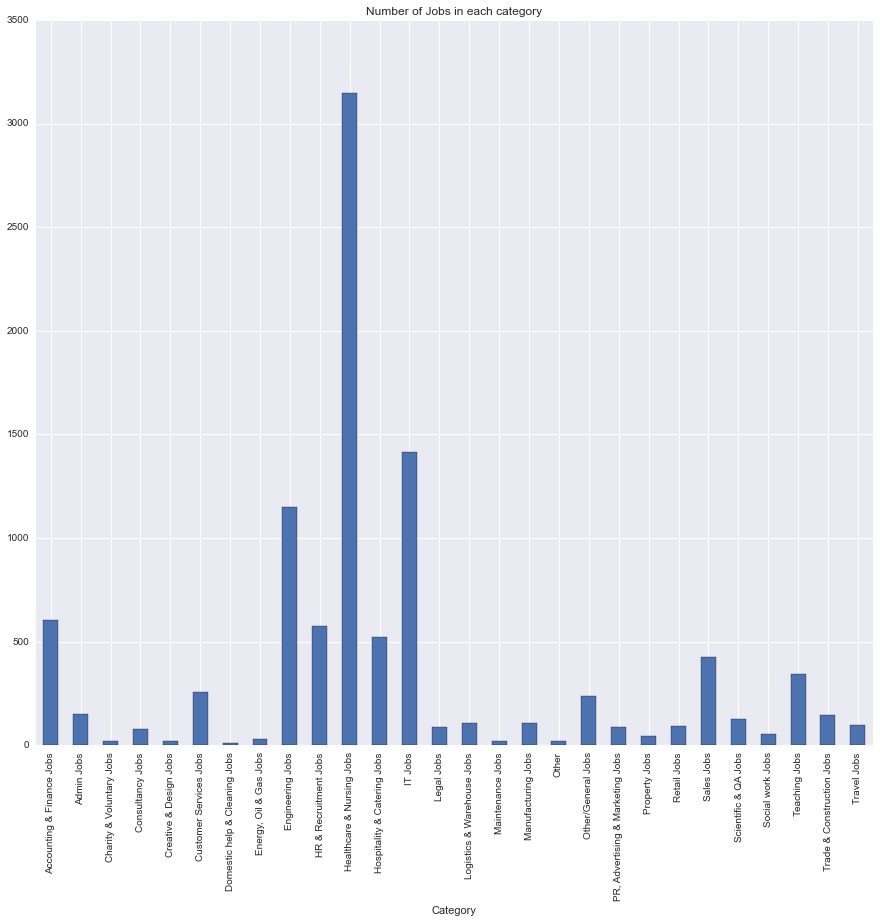

In [12]:
grp2 = jobs_df.groupby('Category')['Id'].count()
my_plot2 = grp2.plot(kind='bar',title="Number of Jobs in each category",figsize=(15, 13))

#### The below code parses through the job titles and  creates a new feature on the base of Seniority 

In [13]:
def estimate_seniority(job_title):
    # Estimates the seniority of a job
    # based on key words in the job title text

    # Input
    # job_title: input text

    # Output
    # seniority: 'junior', 'default', or 'senior'

    seniority = 'default'
    jobtitlewords = str(job_title).lower().split()

    # ignore internships
    if (('intern' in jobtitlewords)
        or ('internship' in jobtitlewords)):
        return 'INTERN'

    senior_words = ['sr',
                    'senior',
                    'lead',
                    'principal',
                    'director',
                    'manager',
                    'cto',
                    'chief',
                    'vp',
                    'head'
                    ]

    junior_words = ['jr',
                    'junior',
                    'associate',
                    'assistant'
                    ]

    for titleword in jobtitlewords:
        titleword = titleword.replace(',', '')
        titleword = titleword.replace('.', '')

        if titleword in senior_words:
            seniority = 'senior'
            break
        elif titleword in junior_words:
            seniority = 'junior'
            break

    return seniority
    

In [14]:
jobs_df['job_level'] = jobs_df['Title'].apply(lambda x: estimate_seniority(x))

#### Created a barchart for number of jobs vs job levels as per above function

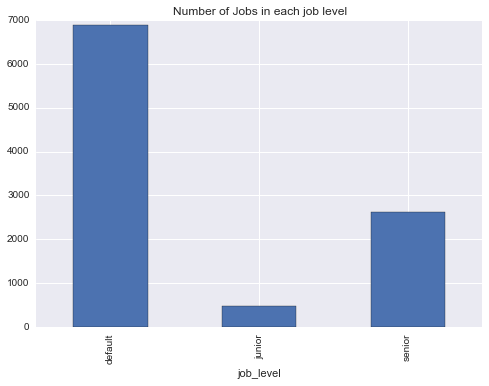

In [16]:
grp3 = jobs_df.groupby('job_level')['Id'].count()
my_plot3 = grp3.plot(kind='bar',title="Number of Jobs in each job level")

#### Created a barchart for average salary for different job levels

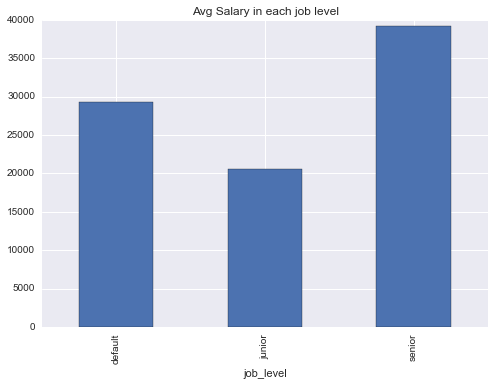

In [18]:
grp4 = jobs_df.groupby('job_level')['SalaryNormalized'].mean()
my_plot4 = grp4.plot(kind='bar',title="Avg Salary in each job level")

#### Created a feature based on whether location is London or not

In [21]:
jobs_df['london'] = 0
def london(row):
    location = row['LocationNormalized']
    if location.lower() == 'london':
        return 1
    else:
        return 0
jobs_df['london'] = jobs_df.apply(london, axis=1)

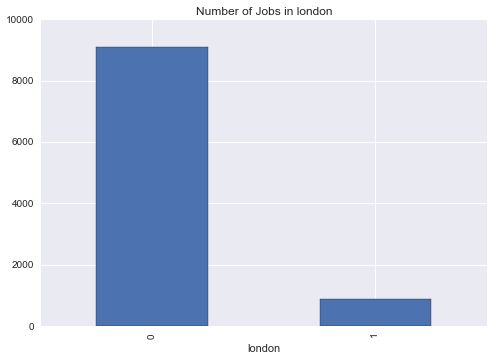

In [22]:
grp5 = jobs_df.groupby('london')['Id'].count()
my_plot5 = grp5.plot(kind='bar',title="Number of Jobs in london")

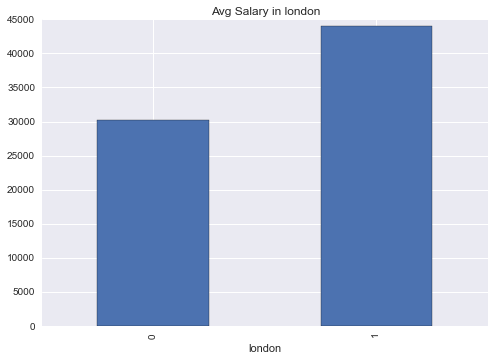

In [23]:
grp6 = jobs_df.groupby('london')['SalaryNormalized'].mean()
my_plot6 = grp6.plot(kind='bar',title="Avg Salary in london")

### Natural Language Processing
#### Calculated term frequencies in job description and calculated tf-idf for job titles
#### Stemming, Remove Stop Words, Tokenize
#### Identified top words based on salary distribution

In [31]:
from nltk.tokenize import WhitespaceTokenizer
from CleanTokenize import CleanAndTokenize
from nltk.corpus import stopwords
import nltk.tag, nltk.util, nltk.stem
from textblob import TextBlob as tb
import math
from collections import Counter

stopword_list = stopwords.words('english')
porter = nltk.PorterStemmer()

In [32]:
def cleanText(comment_text):
    comment_stemmed_tokens = []
    comment_features = {}
    try:
        token_list = CleanAndTokenize(comment_text)
    except:
        if isinstance(comment_text,basestring):
            token_list = comment_text.split()
        else:
            token_list = []
    token_list = [word for word in token_list if word not in stopword_list]
    comment_stemmed_tokens.extend([porter.stem(token) for token in token_list])
    cleaned_Text = ' '.join(comment_stemmed_tokens)
    return cleaned_Text

In [33]:
jobs_df['textTokens'] = jobs_df['FullDescription'].apply(lambda x: cleanText(x))
jobs_df['titleTokens'] = jobs_df['Title'].apply(lambda x: cleanText(x))

In [34]:
JobTitle = jobs_df.groupby('Salary_Range').agg({'titleTokens': 'sum'}).reset_index()
JobDesc = jobs_df.groupby('Salary_Range').agg({'textTokens': 'sum'}).reset_index()
JobTitle.head(n=3)

,Salary_Range,titleTokens
0,20001-27500,engin system analystpioneer miser engin system...
1,27500-37500,stress engin glasgowmodel simul analystengin s...
2,37500-60000,project engin pharmaceutprincip composit stres...


In [35]:
title_dict = dict()
for index, row in JobTitle.iterrows():
    Salary_Range = row['Salary_Range']  
    title_dict[Salary_Range] = tb(row['titleTokens'])
    
text_dict = dict()
for index, row in JobDesc.iterrows():
    Salary_Range = row['Salary_Range']  
    text_dict[Salary_Range] = tb(row['textTokens'])

In [ ]:
bloblist = title_dict.values()
Job_Freq2 = []
for sal_range, blob in title_dict.items():
    print("Top words in salary range {}".format(sal_range))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    temp_list = []
    for word, score in sorted_words[:5]:
        print("\tWord: {}, TF-IDF: {}".format(word.encode('utf-8'), round(score, 5)))
        temp_list.append(word)
        row = [word,score,sal_range]
        Job_Freq2.append(row)

Job_Freq2_df = pd.DataFrame(Job_Freq2)
Job_Freq2_df.columns = ['word','tf-idf score','Salary_Range']
Job_Freq2_df.to_csv('Job_Freq2.csv')

In [37]:
Text_freq = dict()
Job_Freq = []
for index, row in JobDesc.iterrows():
    
    Salary_Range = row['Salary_Range']
    final_text = row['textTokens']
    frequent_words = Counter(final_text.split()).most_common()[:30]
    temp_list = []
    
    for word,count in frequent_words:
        temp_list.append(word)
        row = [word,count,Salary_Range]
        Job_Freq.append(row)
    Text_freq[Salary_Range] = temp_list
    


Job_Freq_df = pd.DataFrame(Job_Freq)
Job_Freq_df.columns = ['word','count','Salary_Range']
Job_Freq_df.to_csv('Job_Freq.csv')

#### Dividing the training data set into 2 one for training and another  for validation 

In [38]:
msk = np.random.rand(len(jobs_df)) < 0.799

train = jobs_df[msk]
test = jobs_df[~msk]
print len(train)
print len(test)

8074
1926


In [39]:
train = train.drop('titleTokens', 1)
train = train.drop('textTokens', 1)

In [40]:
test = test.drop('titleTokens', 1)
test = test.drop('textTokens', 1)

In [41]:
train.to_csv('train-cedited.csv')
test.to_csv('test-cedited.csv')

### Creating/loading mapper and transform functions

In [195]:
import sklearn
from sklearn.base import BaseEstimator
from HTMLParser import HTMLParser

class FeatureMapper:
    def __init__(self, features,new_features):
        self.features = features
        self.new_features = new_features

    def fit(self, X, y=None):
        print "fit"
        for feature_name, column_name, extractor in self.features:
            print "fit"
            extractor.fit(X[column_name], y)



    def transform(self, X):
        extracted = []
        for feature_name, column_name, extractor in self.features:
            fea = extractor.transform(X[column_name])
            if hasattr(fea, "toarray"):
                extracted.append(fea.toarray())
            else:
                extracted.append(fea)
        print "transform"
        if len(extracted) > 1:
            array_final_test = np.concatenate(extracted, axis=1)
        else:
            array_final_test = extracted[0]

        test_df = pd.read_csv('test-cedited.csv')
        combined_features_test = array_final_test
        for feature in self.new_features:
            dummy_test = pd.get_dummies(test_df[feature], prefix=feature)
            features_test = dummy_test.values
            combined_features_test = np.concatenate((combined_features_test,features_test),axis=1)
        return combined_features_test

    def fit_transform(self, X, y=None):
        extracted = []
        for feature_name, column_name, extractor in self.features:
            fea = extractor.fit_transform(X[column_name], y)
            if hasattr(fea, "toarray"):
                extracted.append(fea.toarray())
            else:
                extracted.append(fea)
        print "fit_transform"

        if len(extracted) > 1:
            array_final_train = np.concatenate(extracted, axis=1)
        else:
            array_final_train = extracted[0]

        train_df = pd.read_csv('train-cedited.csv')
        combined_features_train = array_final_train
        for feature in self.new_features:
            dummy_train = pd.get_dummies(train_df[feature], prefix=feature)
            features_train = dummy_train.values
            combined_features_train = np.concatenate((combined_features_train,features_train),axis=1)
            
        return combined_features_train

def identity(x):
    return x

class SimpleTransform(BaseEstimator):
    def __init__(self, transformer=identity):
        self.transformer = transformer

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X)

    def transform(self, X, y=None):
        return np.array([self.transformer(x) for x in X], ndmin=2).T


#### Define feature extractor

In [198]:
train_df = pd.read_csv('train-cedited.csv')

def feature_extractor(new_features):
    features = [('FullDescription-Bag of Words', 'FullDescription', CountVectorizer(max_features=100)),
                ('Title-Bag of Words', 'Title', CountVectorizer(max_features=100)),
                ('LocationRaw-Bag of Words', 'LocationRaw', CountVectorizer(max_features=100)),
                ('LocationNormalized-Bag of Words', 'LocationNormalized', CountVectorizer(max_features=100))]
    
    combined = FeatureMapper(features,new_features)
    return combined


#### Train the dataset with the extracted features

In [199]:
def main(new_features):
    print("Reading in the training data")
    train = data_io.get_train_df()

    print("Extracting features and training model")
    classifier = get_pipeline(new_features)
    classifier.fit(train, train["SalaryNormalized"])

    print("Saving the classifier")
    data_io.save_model(classifier)

#### Function defined for Prediction

In [202]:
def predict():
    print("Loading the classifier")
    classifier = data_io.load_model()
    
    print("Making predictions") 
    valid = data_io.get_valid_df()
    predictions = classifier.predict(valid)   
    predictions = predictions.reshape(len(predictions), 1)

    print("Writing predictions to file")
    data_io.write_submission(predictions)

    predicted_df = pd.read_csv('random_forest_benchmark_rev1.csv')
    predicted_df.columns = ['Id','SalaryPredicted']

    test_df = pd.read_csv('test-cedited.csv')

    test_df = test_df[['Id','SalaryNormalized']]

    final_df = pd.merge(test_df, predicted_df, how='inner', on=['Id'])
    print final_df.head()


    y_true = final_df['SalaryNormalized']
    y_pred = final_df['SalaryPredicted']
    mae = mean_absolute_error(y_true,y_pred)
    mse = mean_squared_error(y_true,y_pred)
    print mae
    print mse

### Random Forest Regressor

In [200]:
def get_pipeline(new_features):
    features = feature_extractor(new_features)
    steps = [("extract_features", features),
             ("classify", RandomForestRegressor(n_estimators=50,
                                                verbose=2,
                                                n_jobs=1,
                                                min_samples_split=30,
                                                random_state=3465343))]
    return Pipeline(steps)


#### Running Train and Predict for Random Forest Regressor. 
#### 
#### Feature Set: Bag of Words (job title, description, location normalized, location raw)

In [210]:
new_features = []
main(new_features)
predict()

Reading in the training data
Extracting features and training model
fit_transform
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
buildin

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   25.6s



building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
Saving the classifier
Loading the classifier
Making predictions
transform

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   31.0s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s



Writing predictions to file
         Id  SalaryNormalized  SalaryPredicted
0  12612628             25000     37518.652883
1  12613049             27500     39230.265682
2  13179816             25000     36118.656937
3  19047429             21000     22222.216077
4  22579462             22000     31095.541277
7676.68021449
140702497.386


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


#### Feature Set: Bag of Words (job title, description, location normalized, location raw) + Category

In [211]:
new_features = ['Category']
main(new_features)
predict()

Reading in the training data
Extracting features and training model
fit_transform
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
buildin

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   29.3s



building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
Saving the classifier
Loading the classifier
Making predictions
transform

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   35.4s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s



Writing predictions to file
         Id  SalaryNormalized  SalaryPredicted
0  12612628             25000     24991.393824
1  12613049             27500     27097.553972
2  13179816             25000     30959.769720
3  19047429             21000     25599.363771
4  22579462             22000     30278.540138
7217.2139415
126894567.268


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


#### Feature Set: Bag of Words (job title, description, location normalized, location raw) +  Category + ContractTime + ContractType

In [212]:
new_features = ['Category','ContractTime','ContractType']
main(new_features)
predict()

Reading in the training data
Extracting features and training model
fit_transform
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
buildin

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   26.3s



building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50
Saving the classifier
Loading the classifier
Making predictions
transform

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   32.1s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s



Writing predictions to file
         Id  SalaryNormalized  SalaryPredicted
0  12612628             25000     25468.458245
1  12613049             27500     27142.757336
2  13179816             25000     30928.761651
3  19047429             21000     26032.924759
4  22579462             22000     29564.107235
7020.73451065
116391748.006


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


### Lasso Linear Regression

In [215]:
def get_pipeline(new_features):
    features = feature_extractor(new_features)
    steps = [("extract_features", features),
             ("classify", linear_model.Lasso(alpha=0.1))]
    return Pipeline(steps)

#### Running Train and Predict for Lasso Linear Regressor. 
#### 
#### Feature Set: Bag of Words (job title, description, location normalized, location raw) +  Category + ContractTime + ContractType

In [216]:
new_features = ['Category','ContractTime','ContractType']
main(new_features)
predict()

Reading in the training data
Extracting features and training model
fit_transform
Saving the classifier
Loading the classifier
Making predictions
transform
Writing predictions to file
         Id  SalaryNormalized  SalaryPredicted
0  12612628             25000     23904.306762
1  12613049             27500     34701.611094
2  13179816             25000     22806.716260
3  19047429             21000     31937.072880
4  22579462             22000     33328.429120
8331.12225276
140811465.738


### Decision Tree Regressor

In [217]:
def get_pipeline(new_features):
    features = feature_extractor(new_features)
    steps = [("extract_features", features),
             ("classify", tree.DecisionTreeRegressor())]
    return Pipeline(steps)

#### Running Train and Predict for - Decision Tree Regressor
#### Feature Set: Bag of Words (job title, description, location normalized, location raw) +  Category + ContractTime + ContractType

In [218]:
new_features = ['Category','ContractTime','ContractType']
main(new_features)
predict()

Reading in the training data
Extracting features and training model
fit_transform
Saving the classifier
Loading the classifier
Making predictions
transform
Writing predictions to file
         Id  SalaryNormalized  SalaryPredicted
0  12612628             25000            25000
1  12613049             27500            25000
2  13179816             25000            62400
3  19047429             21000            15000
4  22579462             22000            25000
9137.6853989
226152471.304


###  Extra Trees Regressor

In [219]:
def get_pipeline(new_features):
    features = feature_extractor(new_features)
    steps = [("extract_features", features),
             ("classify", ExtraTreesRegressor(n_estimators=100,
                                                verbose=2,
                                                n_jobs=1,
                                                min_samples_split=30,
                                                random_state=3465343))]
    return Pipeline(steps)

#### Running Train and Predict for - Extra Trees Regressor
#### Feature Set: Bag of Words (job title, description, location normalized, location raw) +  Category + ContractTime + ContractType

In [220]:
new_features = ['Category','ContractTime','ContractType']
main(new_features)
predict()

Reading in the training data
Extracting features and training model
fit_transform
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 3

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:   33.4s



building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s



Writing predictions to file
         Id  SalaryNormalized  SalaryPredicted
0  12612628             25000     25554.864769
1  12613049             27500     26726.768578
2  13179816             25000     29576.220615
3  19047429             21000     24248.998301
4  22579462             22000     30732.169255
6839.54784603
113095634.498


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### Starting with Classifiers

In [224]:
def main_classifier(new_features):
    print("Reading in the training data")
    train = data_io.get_train_df()

    print("Extracting features and training model")
    classifier = get_pipeline_classifier(new_features)
    classifier.fit(train, train["Salary_Range"])

    print("Saving the classifier")
    data_io.save_model(classifier)
    
def predict_classifier():
    print("Loading the classifier")
    classifier = data_io.load_model()
    
    print("Making predictions") 
    valid = data_io.get_valid_df()
    predictions = classifier.predict(valid)   

    print("Writing predictions to file")
    data_io.write_submission(predictions)


    predicted_df = pd.read_csv('random_forest_benchmark_rev1.csv')
    predicted_df.columns = ['Id','SalaryPredicted']

    test_df = pd.read_csv('test-cedited.csv')

    test_df = test_df[['Id','Salary_Range']]

    final_df = pd.merge(test_df, predicted_df, how='inner', on=['Id'])
    print final_df.head()


    y_true = final_df['Salary_Range']
    y_pred = final_df['SalaryPredicted']

    acc_score = accuracy_score(y_true,y_pred)
    con_matrix = confusion_matrix(y_true,y_pred)
    report = classification_report(y_true,y_pred)
    print acc_score
    print con_matrix
    print report
    
    
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
    cm_normalized = con_matrix.astype('float') / con_matrix.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)


### Random Forest Classifier

In [227]:
def get_pipeline_classifier(new_features):
    features = feature_extractor(new_features)
    steps = [("extract_features", features),
             ("classify", RandomForestClassifier(n_estimators=100,
                                                verbose=2,
                                                n_jobs=1,
                                                min_samples_split=30,
                                                random_state=3465343))]
    return Pipeline(steps)

#### Running Train and Predict for - Random Forest Classifier. 
#### Feature Set: Bag of Words (job title, description, location normalized, location raw)

In [228]:
new_features = []
main_classifier(new_features)
predict_classifier()

Reading in the training data
Extracting features and training model
fit_transform
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 3

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    1.4s



building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s



Writing predictions to file
         Id Salary_Range SalaryPredicted
0  12612628  20001-27500     20001-27500
1  12613049  27500-37500     20001-27500
2  13179816  20001-27500     37500-60000
3  19047429  20001-27500          <20000
4  22579462  20001-27500     27500-37500
0.570998494732
[[299 117  56   0  94]
 [100 250 102   0  36]
 [ 28 106 229   0  27]
 [  6  27  70  17  11]
 [ 46  21   8   0 343]]
             precision    recall  f1-score   support

20001-27500       0.62      0.53      0.57       566
27500-37500       0.48      0.51      0.50       488
37500-60000       0.49      0.59      0.54       390
     60000+       1.00      0.13      0.23       131
     <20000       0.67      0.82      0.74       418

avg / total       0.60      0.57      0.56      1993

Normalized confusion matrix
[[ 0.53  0.21  0.1   0.    0.17]
 [ 0.2   0.51  0.21  0.    0.07]
 [ 0.07  0.27  0.59  0.    0.07]
 [ 0.05  0.21  0.53  0.13  0.08]
 [ 0.11  0.05  0.02  0.    0.82]]


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


#### Feature Set: Bag of Words (job title, description, location normalized, location raw) +  Category + ContractTime + ContractType

In [229]:
new_features = ['Category','ContractTime','ContractType']
main_classifier(new_features)
predict_classifier()

Reading in the training data
Extracting features and training model
fit_transform
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 3

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    1.5s



building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s



Writing predictions to file
         Id Salary_Range SalaryPredicted
0  12612628  20001-27500     20001-27500
1  12613049  27500-37500     20001-27500
2  13179816  20001-27500     27500-37500
3  19047429  20001-27500     20001-27500
4  22579462  20001-27500     27500-37500
0.582037129955
[[298 109  64   0  95]
 [ 95 260 103   0  30]
 [ 34  92 237   5  22]
 [  6  15  75  26   9]
 [ 53  21   5   0 339]]
             precision    recall  f1-score   support

20001-27500       0.61      0.53      0.57       566
27500-37500       0.52      0.53      0.53       488
37500-60000       0.49      0.61      0.54       390
     60000+       0.84      0.20      0.32       131
     <20000       0.68      0.81      0.74       418

avg / total       0.60      0.58      0.57      1993

Normalized confusion matrix
[[ 0.53  0.19  0.11  0.    0.17]
 [ 0.19  0.53  0.21  0.    0.06]
 [ 0.09  0.24  0.61  0.01  0.06]
 [ 0.05  0.11  0.57  0.2   0.07]
 [ 0.13  0.05  0.01  0.    0.81]]


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


#### Feature Set: Bag of Words (job title, description, location normalized, location raw) +  Category + ContractTime + ContractType + Seniority + London

In [230]:
new_features = ['Category','ContractTime','ContractType','job_level','london']
main_classifier(new_features)
predict_classifier()

Reading in the training data
Extracting features and training model
fit_transform
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 3

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    1.4s



building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s



Writing predictions to file
         Id Salary_Range SalaryPredicted
0  12612628  20001-27500     20001-27500
1  12613049  27500-37500     20001-27500
2  13179816  20001-27500     27500-37500
3  19047429  20001-27500     20001-27500
4  22579462  20001-27500     27500-37500
0.591068740592
[[310 113  60   0  83]
 [ 88 273  97   0  30]
 [ 36 103 232   5  14]
 [  8  11  75  29   8]
 [ 56  23   5   0 334]]
             precision    recall  f1-score   support

20001-27500       0.62      0.55      0.58       566
27500-37500       0.52      0.56      0.54       488
37500-60000       0.49      0.59      0.54       390
     60000+       0.85      0.22      0.35       131
     <20000       0.71      0.80      0.75       418

avg / total       0.61      0.59      0.58      1993

Normalized confusion matrix
[[ 0.55  0.2   0.11  0.    0.15]
 [ 0.18  0.56  0.2   0.    0.06]
 [ 0.09  0.26  0.59  0.01  0.04]
 [ 0.06  0.08  0.57  0.22  0.06]
 [ 0.13  0.06  0.01  0.    0.8 ]]


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### ExtraTreesClassifier

In [231]:
def get_pipeline_classifier(new_features):
    features = feature_extractor(new_features)
    steps = [("extract_features", features),
             ("classify", ExtraTreesClassifier(n_estimators=100,
                                                verbose=2,
                                                n_jobs=1,
                                                min_samples_split=30,
                                                random_state=3465343))]
    return Pipeline(steps)

#### Running Train and Predict for - ExtraTreesClassifier 
#### Feature Set: Bag of Words (job title, description, location normalized, location raw)  Category + ContractTime + ContractType + Seniority + London

In [232]:
new_features = ['Category','ContractTime','ContractType','job_level','london']
main_classifier(new_features)
predict_classifier()

Reading in the training data
Extracting features and training model
fit_transform
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 3

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    2.4s



building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 8

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s



Writing predictions to file
         Id Salary_Range SalaryPredicted
0  12612628  20001-27500     20001-27500
1  12613049  27500-37500     20001-27500
2  13179816  20001-27500     27500-37500
3  19047429  20001-27500     20001-27500
4  22579462  20001-27500     27500-37500
0.612644254892
[[325 111  55   1  74]
 [ 78 283  96   3  28]
 [ 38  91 235  10  16]
 [  6  12  58  46   9]
 [ 63  20   3   0 332]]
             precision    recall  f1-score   support

20001-27500       0.64      0.57      0.60       566
27500-37500       0.55      0.58      0.56       488
37500-60000       0.53      0.60      0.56       390
     60000+       0.77      0.35      0.48       131
     <20000       0.72      0.79      0.76       418

avg / total       0.62      0.61      0.61      1993

Normalized confusion matrix
[[ 0.57  0.2   0.1   0.    0.13]
 [ 0.16  0.58  0.2   0.01  0.06]
 [ 0.1   0.23  0.6   0.03  0.04]
 [ 0.05  0.09  0.44  0.35  0.07]
 [ 0.15  0.05  0.01  0.    0.79]]


[Parallel(n_jobs=1)]: Done  41 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### SVM - SVC

In [233]:
def get_pipeline_classifier(new_features):
    features = feature_extractor(new_features)
    steps = [("extract_features", features),
             ("classify", SVC())]
    return Pipeline(steps)

#### Running Train and Predict for - SVM - SVC 
#### Feature Set: Bag of Words (job title, description, location normalized, location raw)  Category + ContractTime + ContractType + Seniority + London

In [234]:
new_features = ['Category','ContractTime','ContractType','job_level','london']
main_classifier(new_features)
predict_classifier()

Reading in the training data
Extracting features and training model
fit_transform
Saving the classifier
Loading the classifier
Making predictions
transform
Writing predictions to file
         Id Salary_Range SalaryPredicted
0  12612628  20001-27500          <20000
1  12613049  27500-37500     20001-27500
2  13179816  20001-27500     27500-37500
3  19047429  20001-27500     20001-27500
4  22579462  20001-27500     20001-27500
0.533366783743
[[311 113  52   1  89]
 [120 234 102   0  32]
 [ 40 129 196   0  25]
 [  8  29  67  15  12]
 [ 69  32  10   0 307]]
             precision    recall  f1-score   support

20001-27500       0.57      0.55      0.56       566
27500-37500       0.44      0.48      0.46       488
37500-60000       0.46      0.50      0.48       390
     60000+       0.94      0.11      0.20       131
     <20000       0.66      0.73      0.70       418

avg / total       0.56      0.53      0.52      1993

Normalized confusion matrix
[[ 0.55  0.2   0.09  0.    0.16]
 [ 0

### Naive Bayes

In [235]:
def get_pipeline_classifier(new_features):
    features = feature_extractor(new_features)
    steps = [("extract_features", features),
             ("classify", MultinomialNB())]
    return Pipeline(steps)

#### Running Train and Predict for - Naive Bayes
#### Feature Set: Bag of Words (job title, description, location normalized, location raw)  Category + ContractTime + ContractType + Seniority + London

In [236]:
new_features = ['Category','ContractTime','ContractType','job_level','london']
main_classifier(new_features)
predict_classifier()

Reading in the training data
Extracting features and training model
fit_transform
Saving the classifier
Loading the classifier
Making predictions
transform
Writing predictions to file
         Id Salary_Range SalaryPredicted
0  12612628  20001-27500     27500-37500
1  12613049  27500-37500     37500-60000
2  13179816  20001-27500     37500-60000
3  19047429  20001-27500          <20000
4  22579462  20001-27500     37500-60000
0.458103361766
[[240 100  71  48 107]
 [119 143 110  65  51]
 [ 40  79 140 102  29]
 [ 17   4  30  73   7]
 [ 51  29   9  12 317]]
             precision    recall  f1-score   support

20001-27500       0.51      0.42      0.46       566
27500-37500       0.40      0.29      0.34       488
37500-60000       0.39      0.36      0.37       390
     60000+       0.24      0.56      0.34       131
     <20000       0.62      0.76      0.68       418

avg / total       0.47      0.46      0.45      1993

Normalized confusion matrix
[[ 0.42  0.18  0.13  0.08  0.19]
 [ 0